# Pre-Processing

In [1]:
from collections import Counter
from datasets import load_dataset
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud



/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys, os
sys.path.append(os.path.abspath("../src"))


In [3]:
from setup_nltk import download_nltk_resources

download_nltk_resources()

from preprocessing import preprocess_text

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/saraborello/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saraborello/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/saraborello/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/saraborello/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/saraborello/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
ds = load_dataset("FredZhang7/all-scam-spam")
df = ds["train"].to_pandas()

# Missing values

In [5]:
missing_counts = df.isnull().sum()
missing_counts


text       0
is_spam    0
dtype: int64

In [6]:
df.columns

Index(['text', 'is_spam'], dtype='object')

# EDA

### General Statistics

In [9]:
print("Text length distribution:")
df['text_length'] = df['text'].apply(lambda x: len(str(x)))
df['text_length'].describe()

Text length distribution:


count     42619.000000
mean       1562.196204
std        4989.596299
min           2.000000
25%         234.000000
50%         632.000000
75%        1485.000000
max      299456.000000
Name: text_length, dtype: float64

is_spam
0    25187
1    17432
Name: count, dtype: int64


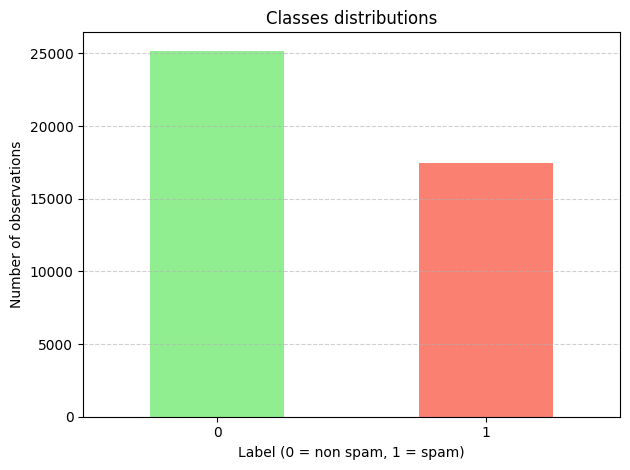

In [10]:
label_counts = df["is_spam"].value_counts()

print(label_counts)

label_counts.plot(kind="bar", color=["lightgreen", "salmon"])
plt.xticks(rotation=0)
plt.title("Classes distributions")
plt.xlabel("Label (0 = non spam, 1 = spam)")
plt.ylabel("Number of observations")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [11]:
proportions = df["is_spam"].value_counts(normalize=True) * 100
proportions.round(2)

is_spam
0    59.1
1    40.9
Name: proportion, dtype: float64

In [12]:
DetectorFactory.seed = 0

def detect_language_safe(text):
    try:
        return detect(text)
    except LangDetectException:
        return "unknown"

df["language"] = df["text"].apply(detect_language_safe)

print(df["language"].value_counts())


language
en         40481
es           220
fr           214
de           181
pt           147
ja           120
ca           111
so            96
ru            90
zh-cn         85
nl            83
af            75
ar            61
cy            59
pl            58
hi            57
it            52
no            45
id            43
da            38
tl            30
tr            29
sw            26
ko            26
sv            21
ro            20
sq            20
et            19
sl            16
hr            14
sk            12
bg            10
unknown       10
fi             8
vi             6
hu             6
mr             6
mk             5
uk             5
bn             5
cs             4
lt             2
ne             2
ur             1
Name: count, dtype: int64


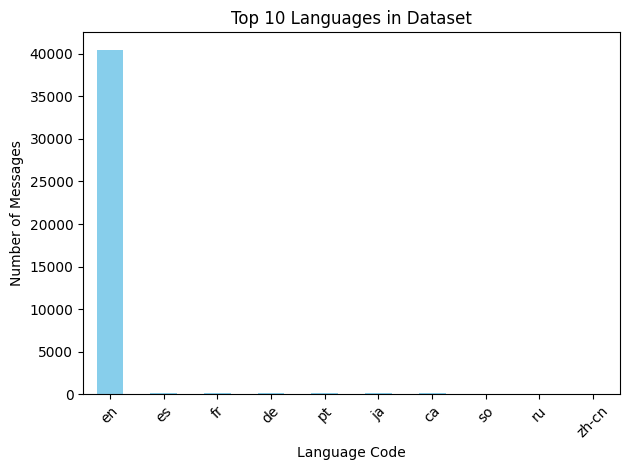

In [13]:
df["language"].value_counts().head(10).plot(kind="bar", color="skyblue")
plt.title("Top 10 Languages in Dataset")
plt.xlabel("Language Code")
plt.ylabel("Number of Messages")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [14]:
df = df[df["language"] == "en"].copy()

For simplicity and consistency in preprocessing and modeling, we filtered the dataset to include only messages written in English. This decision allows us to avoid handling multilingual stopword lists and language-specific preprocessing rules, and ensures that the models are trained on linguistically homogeneous data.

is_spam
0    59.183321
1    40.816679
Name: proportion, dtype: float64


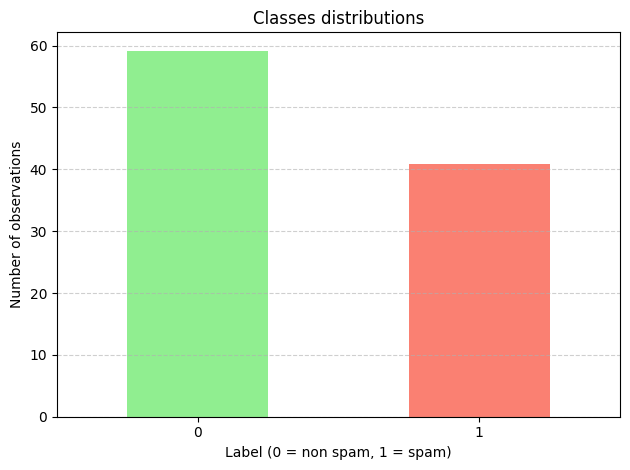

In [17]:
label_counts = df["is_spam"].value_counts(normalize=True) * 100

print(label_counts)

label_counts.plot(kind="bar", color=["lightgreen", "salmon"])
plt.xticks(rotation=0)
plt.title("Classes distributions")
plt.xlabel("Label (0 = non spam, 1 = spam)")
plt.ylabel("Number of observations")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

### Words Description

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\keita\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


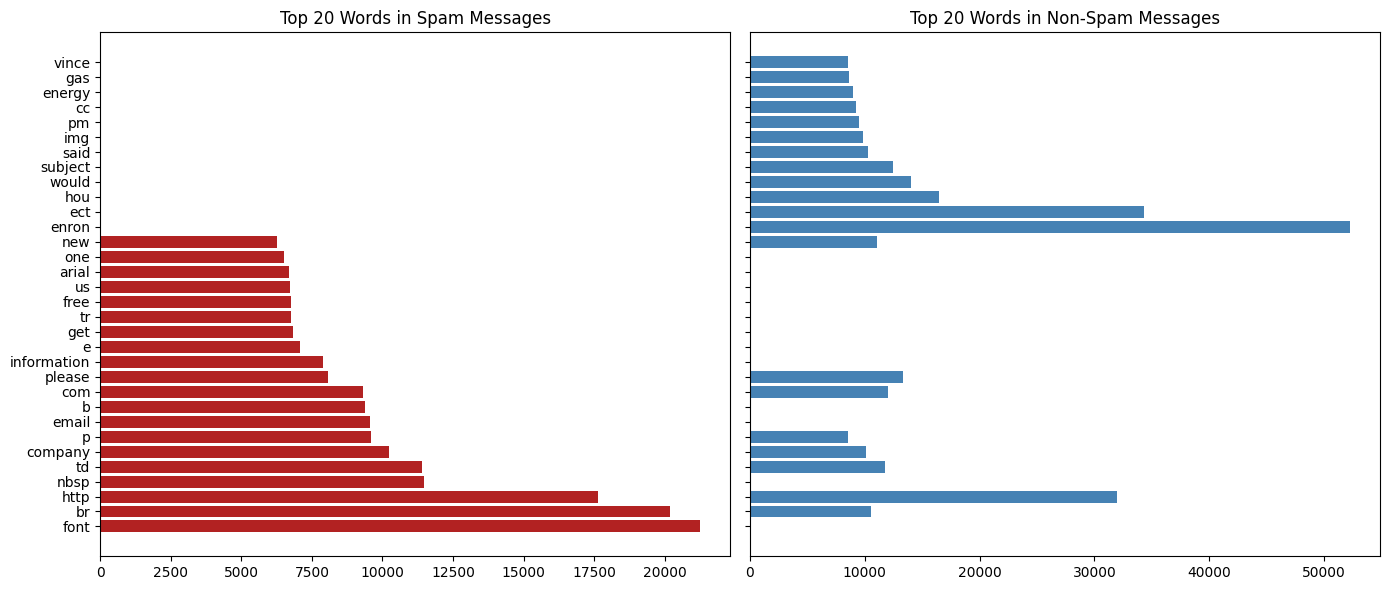

In [ ]:
nltk.download('punkt')

stop_words = set(stopwords.words("english"))

def tokenize_and_filter(text):
    tokens = word_tokenize(text.lower())
    return [t for t in tokens if t.isalpha() and t not in stop_words]

spam_words = df[df["is_spam"] == 1]["text"].apply(tokenize_and_filter).explode()
ham_words = df[df["is_spam"] == 0]["text"].apply(tokenize_and_filter).explode()

spam_freq = Counter(spam_words)
ham_freq = Counter(ham_words)

top_spam = pd.DataFrame(spam_freq.most_common(20), columns=["word", "count"])
top_ham = pd.DataFrame(ham_freq.most_common(20), columns=["word", "count"])

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

axes[0].barh(top_spam["word"], top_spam["count"], color="firebrick")
axes[0].set_title("Top 20 Words in Spam Messages")
axes[0].invert_yaxis()

axes[1].barh(top_ham["word"], top_ham["count"], color="steelblue")
axes[1].set_title("Top 20 Words in Non-Spam Messages")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


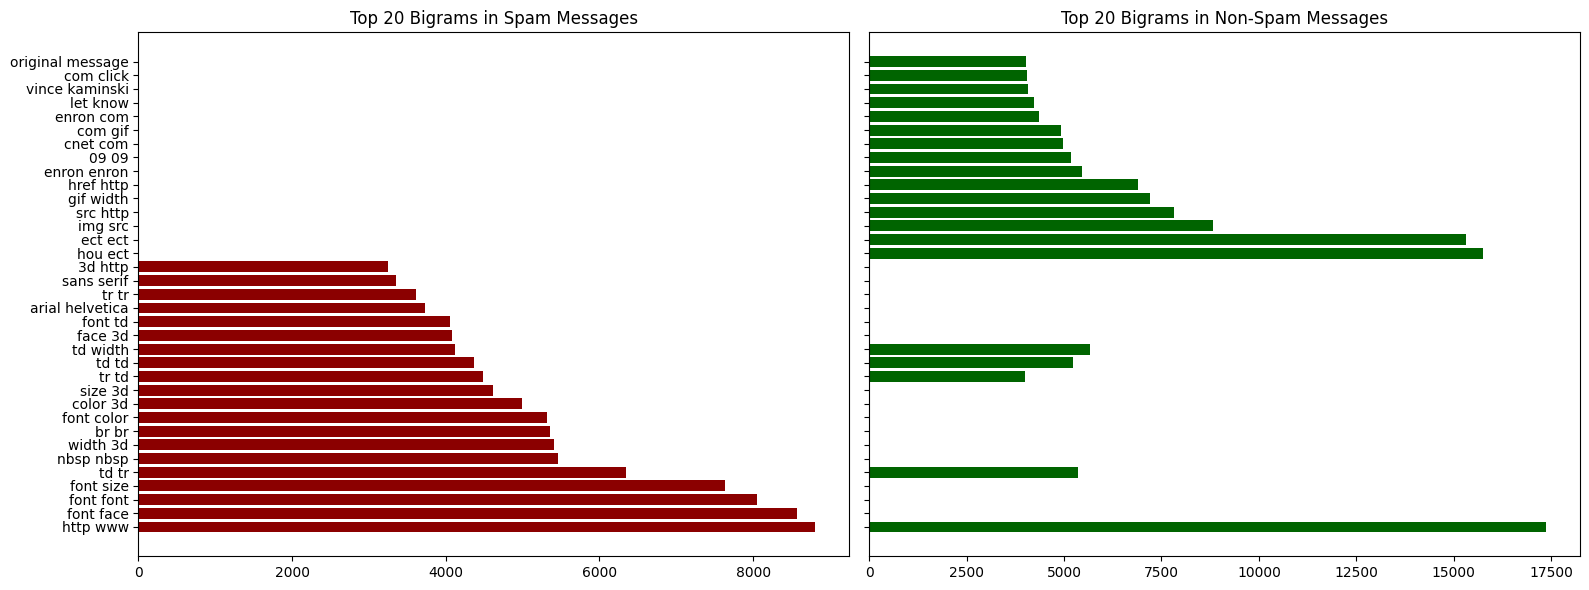

In [51]:
def get_top_ngrams(corpus, ngram_range=(2, 2), n=20):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return pd.DataFrame(words_freq[:n], columns=["bigram", "count"])

spam_bigrams = get_top_ngrams(df[df["is_spam"] == 1]["text"], ngram_range=(2, 2))

ham_bigrams = get_top_ngrams(df[df["is_spam"] == 0]["text"], ngram_range=(2, 2))

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

axes[0].barh(spam_bigrams["bigram"], spam_bigrams["count"], color="darkred")
axes[0].set_title("Top 20 Bigrams in Spam Messages")
axes[0].invert_yaxis()

axes[1].barh(ham_bigrams["bigram"], ham_bigrams["count"], color="darkgreen")
axes[1].set_title("Top 20 Bigrams in Non-Spam Messages")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


<>:5: SyntaxWarning: invalid escape sequence '\$'
<>:5: SyntaxWarning: invalid escape sequence '\$'
C:\Users\keita\AppData\Local\Temp\ipykernel_11624\4072575503.py:5: SyntaxWarning: invalid escape sequence '\$'
  df["num_dollars"] = df["text"].str.count("\$")


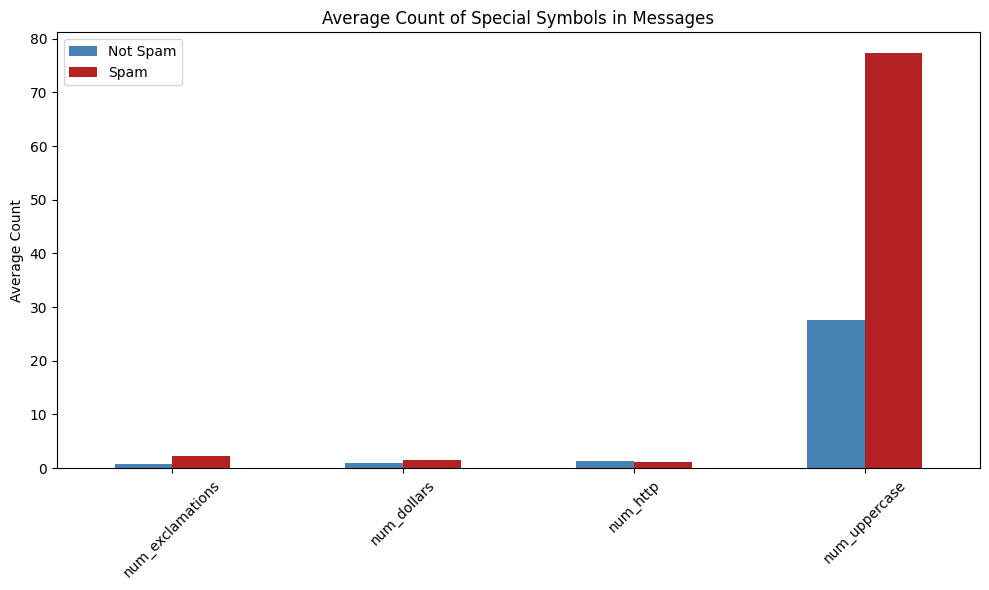

In [ ]:
df["num_exclamations"] = df["text"].str.count("!")
df["num_dollars"] = df["text"].str.count("\$")
df["num_http"] = df["text"].str.count(r"http\S*")
df["num_uppercase"] = df["text"].apply(lambda x: sum(1 for c in str(x) if c.isupper()))

features = ["num_exclamations", "num_dollars", "num_http", "num_uppercase"]
mean_values = df.groupby("is_spam")[features].mean().T
mean_values.columns = ["Not Spam", "Spam"]

mean_values.plot(kind="bar", figsize=(10, 6), color=["steelblue", "firebrick"])
plt.title("Average Count of Special Symbols in Messages")
plt.ylabel("Average Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Split train and test 

In [58]:
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["is_spam"], test_size=0.2, stratify=df["is_spam"])

In [59]:
train_df = pd.DataFrame({"text": X_train, "label": y_train})
test_df = pd.DataFrame({"text": X_test, "label": y_test})
train_df.to_csv("../data/splits/raw/train.csv", index=False)
test_df.to_csv("../data/splits/raw/test.csv", index=False)

# Preprocessing

Distilbert does not need any preprocessing so it will be finetuning without any preprocessing while logistic regression needs preprocessing

In [61]:
train_df["clean_text"] = train_df["text"].apply(preprocess_text)
test_df["clean_text"] = test_df["text"].apply(preprocess_text)

In [24]:
train_df.head()

,text,label,clean_text
10763,fre @ backgammon\n\nisrael approved plans this...,1,fre backgammon israel approv plan week major o...
9329,re : waha hubco\n\nwaha hubco :\nlinda are you...,0,waha hubco waha hubco linda go work primari in...
41771,Como se chama isso em português?,0,como se chama isso em portuguê
28366,wellesley list\n\ngeynille :\nhere is the list...,0,wellesley list geynil list woman attend presen...
7807,potential list for november\n\ndaren :\nhere i...,0,potenti list novemb daren list potenti deal no...


In [25]:
train_df["clean_text"]

10763    fre backgammon israel approv plan week major o...
9329     waha hubco waha hubco linda go work primari in...
41771                       como se chama isso em portuguê
28366    wellesley list geynil list woman attend presen...
7807     potenti list novemb daren list potenti deal no...
                               ...                        
6329     activ driver quantiti survey awar start collec...
42094                                        我正在看一本很有趣的书！📚
15190    candlestick chart fyi fallout forward mike rob...
34385    stock radar crow vcsc brand new stock attent v...
35855    someth unusu product less top second could loo...
Name: clean_text, Length: 34095, dtype: object

In [12]:
test_df["clean_text"]

22015    yummi frappachino hey let go get coffe realli ...
19522    rawhid present louis updat earlier version raw...
17185    california updat sourc report socal chairman j...
13556    vacat shirley problem vinc shirley crenshaw pm...
36779                                       spoil bed well
                               ...                        
13844    friday brown bag lunch option price vinc thank...
29542    old put wet horni dirti grandma rememb lust fr...
33213    new password dear applic applic process approv...
31252    revis weekend duti revis schedul equit cover r...
2316     alevel student sue � grade fix url date educ y...
Name: clean_text, Length: 8524, dtype: object

In [62]:
train_df.to_csv("../data/splits/train.csv", index=False)
test_df.to_csv("../data/splits/test.csv", index=False)

# Visualization

In [ ]:
texts = df["clean_text"].dropna().astype(str)

# CO-OCCURRENCE MATRIX
vectorizer = CountVectorizer(stop_words="english", max_features=1000)
X = vectorizer.fit_transform(texts)


cooccurrence_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
cooccurrence_matrix = cooccurrence_df.T @ cooccurrence_df

focus_word = "money"  
if focus_word in cooccurrence_matrix.columns:
    print(f"🔗 Parole più co-occorenti con '{focus_word}':")
    display(cooccurrence_matrix[focus_word].sort_values(ascending=False)[1:11])
else:
    print(f"La parola '{focus_word}' non è tra le top features selezionate.")

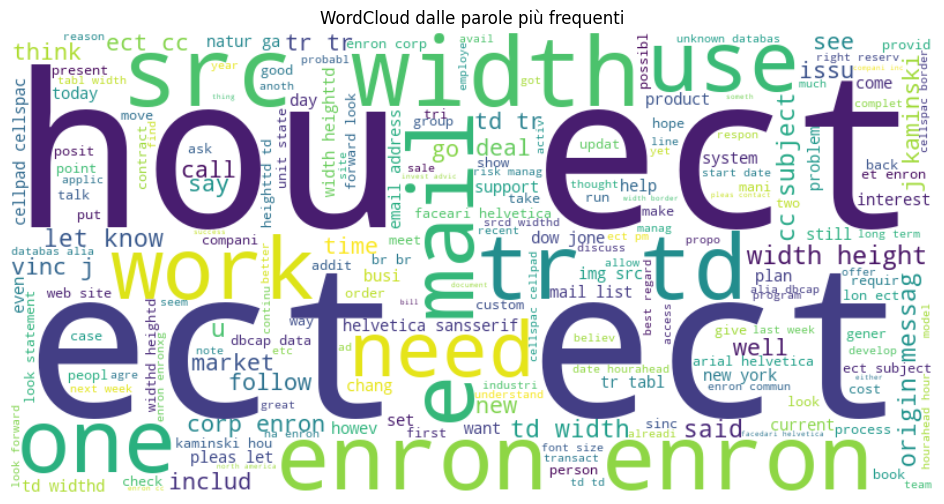

In [17]:
all_text = " ".join(train_df["clean_text"].dropna().astype(str).tolist())

#wordcloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    max_words=200,
    colormap="viridis"
).generate(all_text)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud dalle parole più frequenti")
plt.show()
